## 1. Importing Libraries

In this section, we import all the required Python libraries used throughout the notebook. These libraries help us with:

- Data loading and manipulation (`pandas`, `numpy`)
- Text processing and feature extraction (`nltk`, `re`, `TfidfVectorizer`)
- Sentiment analysis (`TextBlob`, `SentimentIntensityAnalyzer`)
- Machine learning models and evaluation (`sklearn`)
- Visualizations (`matplotlib`, `seaborn`, `plotly`, `wordcloud`)
- Saving/loading models (`pickle`)

In [113]:
# Data handling and utilities
import pandas as pd
import numpy as np
import pickle
import time

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots

# Text preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

# NLP and sentiment analysis
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

In [114]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/samiransari/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samiransari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/samiransari/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/samiransari/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [115]:
# Define file paths for the dataset
true_news_path = "../data/True.csv"
fake_news_path = "../data/Fake.csv"

In [117]:
def load_dataset(true_news_path, fake_news_path):
    """
    Load and combine true and fake news datasets.
    
    - Adds binary labels: 1 for true news, 0 for fake news
    - Combines and shuffles both datasets
    """
    # Load datasets from CSV files
    true_news = pd.read_csv(true_news_path)
    fake_news = pd.read_csv(fake_news_path)
    
    # Assign labels: 1-> true news, 0-> for fake news
    true_news['label'] = 1
    fake_news['label'] = 0

    # Combine the datasets
    full_dataset = pd.concat([true_news, fake_news], ignore_index=True)

    # Shuffle the combined dataset to randomize it
    full_dataset = full_dataset.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return full_dataset


In [118]:
df = load_dataset(true_news_path, fake_news_path)

# Data Exploration

We begin by taking a closer look at the dataset to understand what kind of news content we’re working with. This is a merged dataset of real and fake news articles sourced from Kaggle. Each entry includes metadata like title, subject category, publication date, and the full article text, along with a binary label indicating whether the news is fake (0) or real (1).

This step helps us verify that:
- The data has been loaded properly
- The structure makes sense for text classification
- There are no obvious issues like duplicate entries or misaligned labels

We’re especially interested in the `text` column since that’s what we’ll use to train our machine learning models. Columns like `title` and `subject` might be useful for analysis or feature engineering, but the main focus will be on the article body.

Let’s start by checking how many records we have and get a quick glance at the content.


In [119]:
df.shape

(44898, 5)

In [120]:
# Columns included in the dataset
df.columns.tolist()

['title', 'text', 'subject', 'date', 'label']

In [121]:
# Sample data
df.head()

,title,text,subject,date,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",0
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",0
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",0
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",1
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",0


In [122]:
# Class distribution
df['label'].value_counts()

label
0    23481
1    21417
Name: count, dtype: int64

In [123]:
# Check if there is any missing values
df.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

## Feature Engineering: Text-Based Metrics

To support classification, we create a set of features that capture structural and stylistic patterns in the news articles.

Some signals like high use of uppercase words, excessive punctuation, or unusual sentence structure are more common in clickbait or fake news. These features may help the model pick up on such patterns even before diving into semantic meaning.

In [124]:
# Basic text-level features
df['text_length'] = df['text'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)              # Total character count
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)       # Total number of words
df['sentence_count'] = df['text'].apply(lambda x: len(re.split(r'[.!?]+', str(x))) if pd.notna(x) else 0)  # Approximate sentence count

# Word quality metrics
df['avg_word_length'] = df['text'].apply(
    lambda x: np.mean([len(word) for word in str(x).split()]) 
    if pd.notna(x) and len(str(x).split()) > 0 else 0
)  # Average word length

# Emphasis indicators (used often in fake news)
df['uppercase_word_count'] = df['text'].apply(
    lambda x: len([word for word in str(x).split() if word.isupper() and len(word) > 1]) 
    if pd.notna(x) else 0
)

df['uppercase_ratio'] = df.apply(
    lambda row: row['uppercase_word_count'] / row['word_count'] if row['word_count'] > 0 else 0, axis=1
)

# Special punctuation signals
df['question_mark_count'] = df['text'].apply(lambda x: str(x).count('?') if pd.notna(x) else 0)
df['exclamation_mark_count'] = df['text'].apply(lambda x: str(x).count('!') if pd.notna(x) else 0)

# General punctuation usage
df['punctuation_count'] = df['text'].apply(
    lambda x: len([c for c in str(x) if c in '.,;:!?()[]{}"\'']) if pd.notna(x) else 0
)

df['punctuation_ratio'] = df.apply(
    lambda row: row['punctuation_count'] / row['text_length'] if row['text_length'] > 0 else 0, axis=1
)

## Class Distribution

Before training a classifier, it's important to check if the dataset is balanced across classes.

The bar chart below shows how many samples we have for each class in the dataset:

- **0** represents *fake* news articles
- **1** represents *real* news articles

This confirms that the dataset is relatively balanced between the two categories, which is important to ensure fair training and evaluation of our models without introducing bias toward one class.


Text(0, 0.5, 'Count')

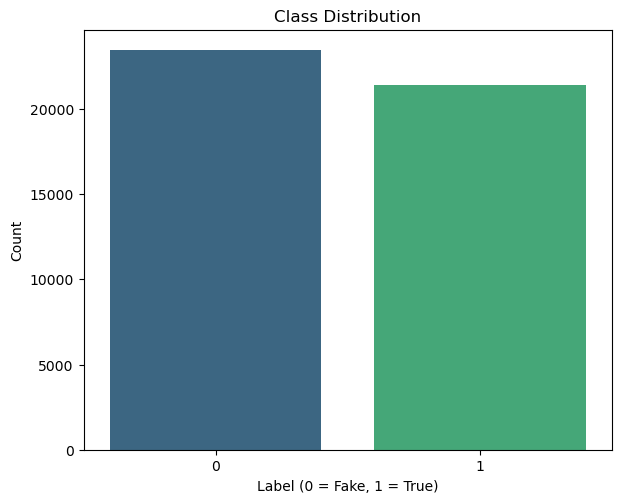

In [127]:
plt.figure(figsize=(15, 12))

# Plot class distribution (Fake vs. Real)
plt.subplot(2, 2, 1)
sns.countplot(x='label', hue='label', data=df, palette='viridis', legend=False)
plt.title('Class Distribution')
plt.xlabel('Label (0 = Fake, 1 = True)')
plt.ylabel('Count')

### Text Length Distribution by Class

This histogram compares the length of article texts across fake (`label = 0`) and real (`label = 1`) news.

Observations:
- Most articles, regardless of label, fall below 10,000 characters in length.
- Fake news articles (blue) tend to slightly dominate the shorter lengths, suggesting they may be more concise or less detailed.
- Real news (orange) has a more noticeable presence in the mid-length range, possibly due to more structured reporting.

These kinds of structural differences can be useful signals for the classifier, especially when combined with other textual features.


Text(0, 0.5, 'Count')

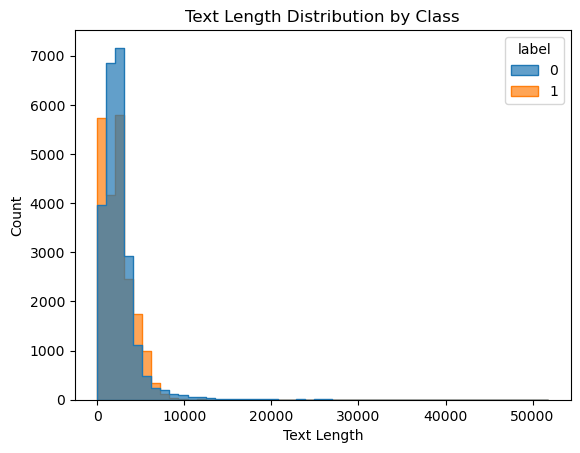

In [129]:
sns.histplot(data=df, x='text_length', hue='label', bins=50, alpha=0.7, element="step")
plt.title('Text Length Distribution by Class')
plt.xlabel('Text Length')
plt.ylabel('Count')

### Word Count by Class
Observations:
- Both distributions have similar medians, but fake news shows a slightly wider range and more outliers.
- Fake articles tend to have more extreme cases with very high word counts.
- Real news articles are more tightly clustered, which may reflect consistent editorial standards or formatting.

These patterns can be informative for classification, especially when paired with other linguistic and structural features.

Text(0, 0.5, 'Word Count')

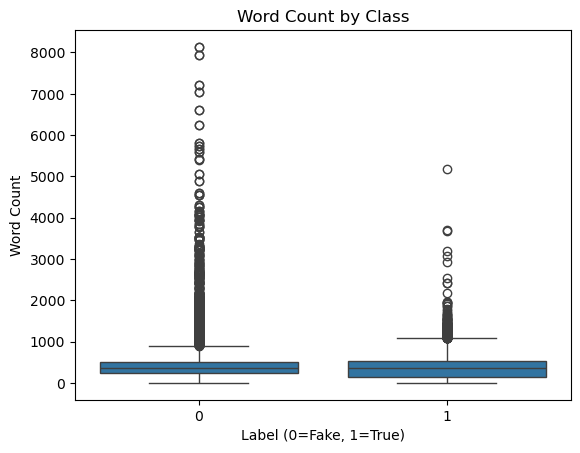

In [16]:
sns.boxplot(x='label', y='word_count', data=df)
plt.title('Word Count by Class')
plt.xlabel('Label (0=Fake, 1=True)')
plt.ylabel('Word Count')

### Sentence Count by Class
Observations:
- Both classes have a similar median sentence count, with most articles falling in the 10–40 sentence range.
- Fake news articles show more extreme outliers, including some with over 700 sentences, which could indicate noise, scraping errors, or spam-like content.
- Real news articles tend to be more consistent in structure, which reflects editorial standards in reputable sources.

Sentence count, like word count, can help the model detect structural patterns between credible and non-credible sources.


Text(0, 0.5, 'Sentence Count')

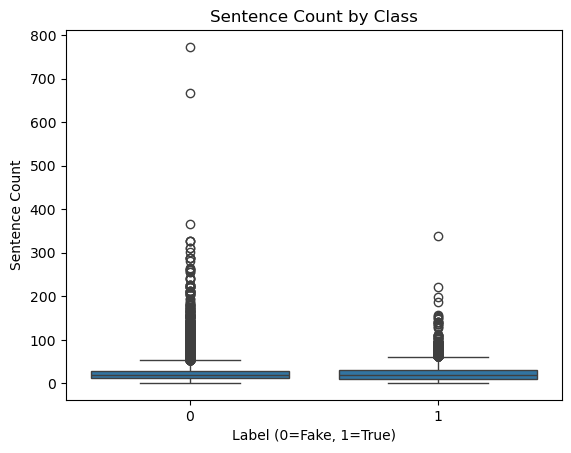

In [17]:
# Sentence count distribution
sns.boxplot(x='label', y='sentence_count', data=df)
plt.title('Sentence Count by Class')
plt.xlabel('Label (0=Fake, 1=True)')b
plt.ylabel('Sentence Count')

### Average Word Length by Class

This boxplot shows how the average word length differs between fake (`0`) and real (`1`) news articles.

Observations:
- Most articles, regardless of class, have an average word length between 4 and 6 characters — fairly normal for English text.
- A few extreme outliers in the fake news category show unusually high average word lengths, likely due to parsing issues or malformed content (e.g., URLs, repeated tokens, or encoding errors).
- Aside from outliers, the distributions are nearly identical, suggesting this feature alone may not be strongly discriminative, but could still help when combined with others.

This feature helps catch structural oddities that might signal spammy or low-quality content.


Text(0, 0.5, 'Average Word Length')

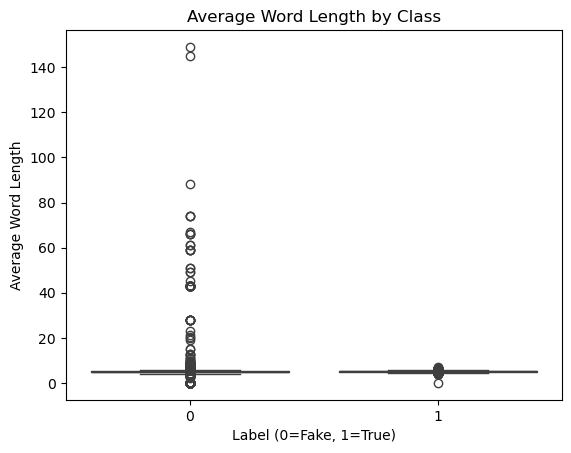

In [18]:
# Average word length by class
sns.boxplot(x='label', y='avg_word_length', data=df)
plt.title('Average Word Length by Class')
plt.xlabel('Label (0=Fake, 1=True)')
plt.ylabel('Average Word Length')

### Uppercase Word Ratio by Class

This boxplot shows how often articles use fully capitalized words (like "BREAKING", "URGENT", etc.) relative to their overall word count.

Observations:
- Fake news (`label = 0`) shows a noticeably higher number of extreme outliers with large uppercase word ratios.
- Real news (`label = 1`) tends to stay within a narrow, lower range, indicating more formal and restrained writing.
- The higher ratio of uppercase words in fake news may reflect attempts to sensationalize or grab attention — a common trait in misinformation.

This feature is useful because it captures a stylistic tone difference between credible and misleading sources.

Text(0, 0.5, 'Uppercase Ratio')

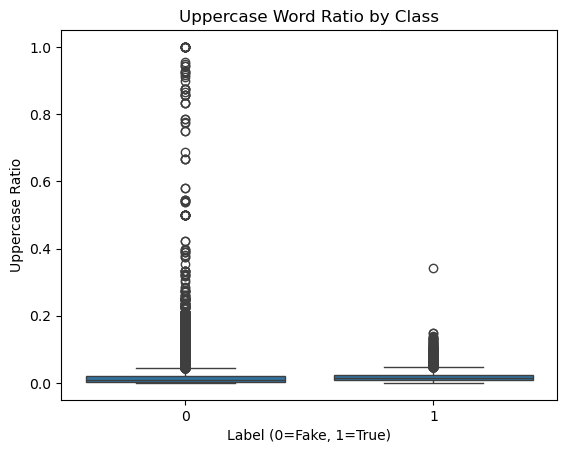

In [131]:
sns.boxplot(x='label', y='uppercase_ratio', data=df)
plt.title('Uppercase Word Ratio by Class')
plt.xlabel('Label (0=Fake, 1=True)')
plt.ylabel('Uppercase Ratio')

### Question Mark Count by Class

This boxplot shows how often question marks appear in articles labeled as fake (`0`) or real (`1`).

Observations:
- Fake news shows a higher frequency of question marks, including extreme outliers.
- This might reflect a common fake news tactic: using loaded questions or rhetorical headlines to provoke emotions or imply conspiracy.
- Real news tends to use fewer question marks, often sticking to factual reporting rather than suggestive language.

This is a good signal that may help separate misleading content from credible reporting.

Text(0, 0.5, 'Question Mark Count')

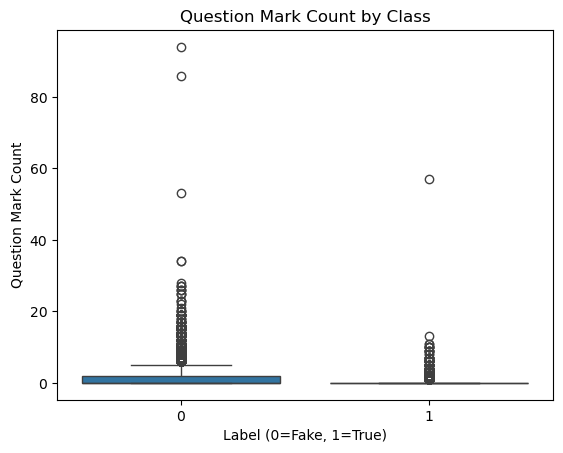

In [20]:
sns.boxplot(x='label', y='question_mark_count', data=df)
plt.title('Question Mark Count by Class')
plt.xlabel('Label (0=Fake, 1=True)')
plt.ylabel('Question Mark Count')

### Exclamation Mark Count by Class

This plot compares the number of exclamation marks in fake vs. real news articles.

Observations:
- Fake news articles again show more outliers with high usage of exclamation marks — a sign of emotional or sensational writing.
- Real news generally avoids this style, staying more neutral and formal in tone.
- Excessive punctuation like this can be a subtle but effective indicator of content quality and credibility.

Together with other style-based features, this helps the model recognize patterns of exaggeration or clickbait behavior.

Text(0, 0.5, 'Exclamation Mark Count')

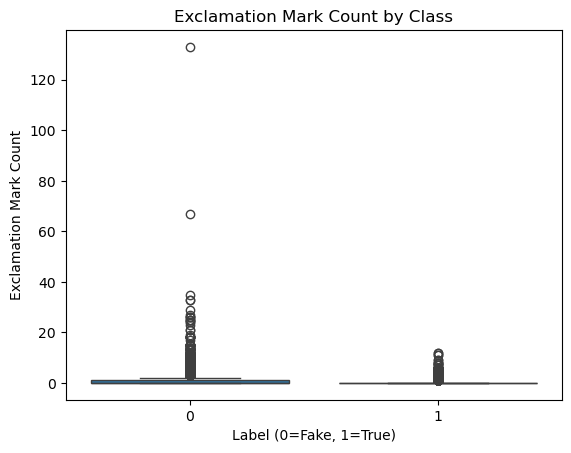

In [21]:
sns.boxplot(x='label', y='exclamation_mark_count', data=df)
plt.title('Exclamation Mark Count by Class')
plt.xlabel('Label (0=Fake, 1=True)')
plt.ylabel('Exclamation Mark Count')

### Sentiment and Subjectivity Features

In this step, we extract emotional and stylistic cues from the article text using two tools:

- **VADER SentimentIntensityAnalyzer**: A rule-based model tuned for social media and short-form text. It outputs:
  - `sentiment_compound`: Overall sentiment score, ranging from -1 (most negative) to +1 (most positive).
  - `sentiment_positive`: The portion of the text classified as positive sentiment.

- **TextBlob**:
  - `subjectivity`: Score from 0 (very objective) to 1 (highly subjective). Subjective content often includes opinions, personal beliefs, or speculation — traits that may appear more frequently in fake news.

These features help quantify how emotionally charged or opinionated an article is, which are useful indicators in distinguishing credible journalism from manipulation or propaganda.


In [22]:
# Sentiment analysis
sia = SentimentIntensityAnalyzer()
df['sentiment_compound'] = df['text'].apply(lambda x: 
                                               sia.polarity_scores(str(x))['compound'] 
                                               if pd.notna(x) else 0)

In [23]:
df['sentiment_positive'] = df['text'].apply(lambda x: 
                                                  sia.polarity_scores(str(x))['pos'] 
                                                  if pd.notna(x) else 0)

In [24]:
# Subjectivity (using TextBlob)
df['subjectivity'] = df['text'].apply(lambda x: 
                                         TextBlob(str(x)).sentiment.subjectivity 
                                         if pd.notna(x) else 0)

#### Sentiment Compound by Class

This plot compares the overall sentiment polarity (`compound` score from VADER) between fake (`0`) and real (`1`) news articles.

Observations:
- Fake news tends to skew more negative, as shown by the lower median compound score.
- Real news shows a more neutral sentiment distribution overall, but with a slightly higher center.
- Both classes span the full range from -1 (very negative) to +1 (very positive), but the tonal lean of fake news is visibly different.

This emotional polarity can be a useful feature — fake articles often exaggerate threats or outrage, which may reflect in stronger sentiment scores.


Text(0, 0.5, 'Sentiment Compound')

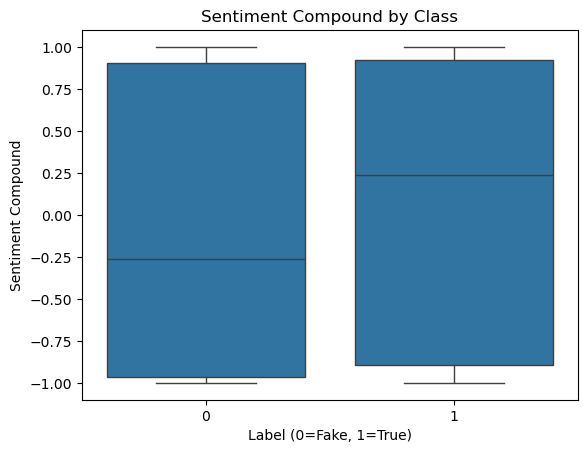

In [25]:
sns.boxplot(x='label', y='sentiment_compound', data=df)
plt.title('Sentiment Compound by Class')
plt.xlabel('Label (0=Fake, 1=True)')
plt.ylabel('Sentiment Compound')

#### Subjectivity by Class

This plot compares the subjectivity scores of fake (`0`) vs. real (`1`) news articles. A score of `0` means fully objective (factual), while `1` means highly subjective (opinionated or emotionally driven).

Observations:
- Fake news tends to have higher subjectivity, with more articles leaning toward personal opinion, speculation, or emotionally loaded language.
- Real news articles are generally more objective, though they still contain some variance — likely due to editorials or opinion sections in legitimate sources.

This feature reflects one of the core behavioral differences in misinformation: fake articles often try to persuade readers, while real articles aim to inform readers.

Text(0, 0.5, 'Subjectivity')

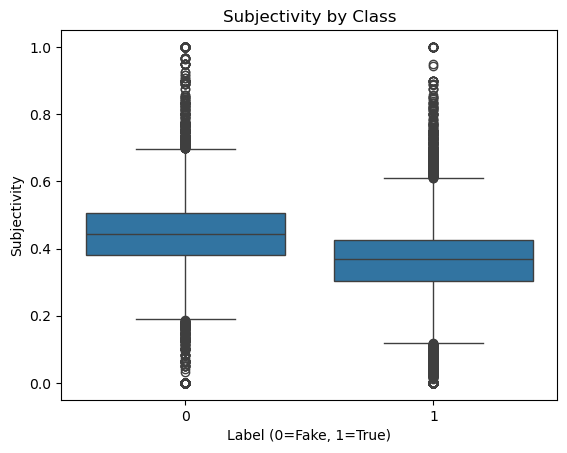

In [26]:
sns.boxplot(x='label', y='subjectivity', data=df)
plt.title('Subjectivity by Class')
plt.xlabel('Label (0=Fake, 1=True)')
plt.ylabel('Subjectivity')

### Most Common Words in Fake News

This word cloud shows the most frequently used words in fake news articles. To focus on meaningful content, we removed both standard stopwords and a custom list of generic verbs and fillers (e.g., "said", "will", "also").

Observations:
- Words like **"Trump"**, **"people"**, **"country"**, and **"state"** dominate the fake news text, suggesting a strong focus on political and national topics.
- Other frequent terms such as **"attack"**, **"support"**, **"left"**, **"Democrat"**, and **"Republican"** hint at partisan language, often used to provoke reaction or bias.
- Sensational phrasing and emotionally charged themes (e.g., **"think"**, **"need"**, **"believe"**, **"fake"**) are also visible, supporting the idea that fake news often leverages emotional triggers.

This visual reinforces the stylistic and topical patterns that separate fake articles from real ones — useful for both manual analysis and feature engineering.


In [32]:
# Set up custom stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['said', 'say', 'says', 'will', 'now', 'one', 'also', 'even', 'new', 'get', 'may'])

Text(0.5, 1.0, 'Most Common Words in Fake News')

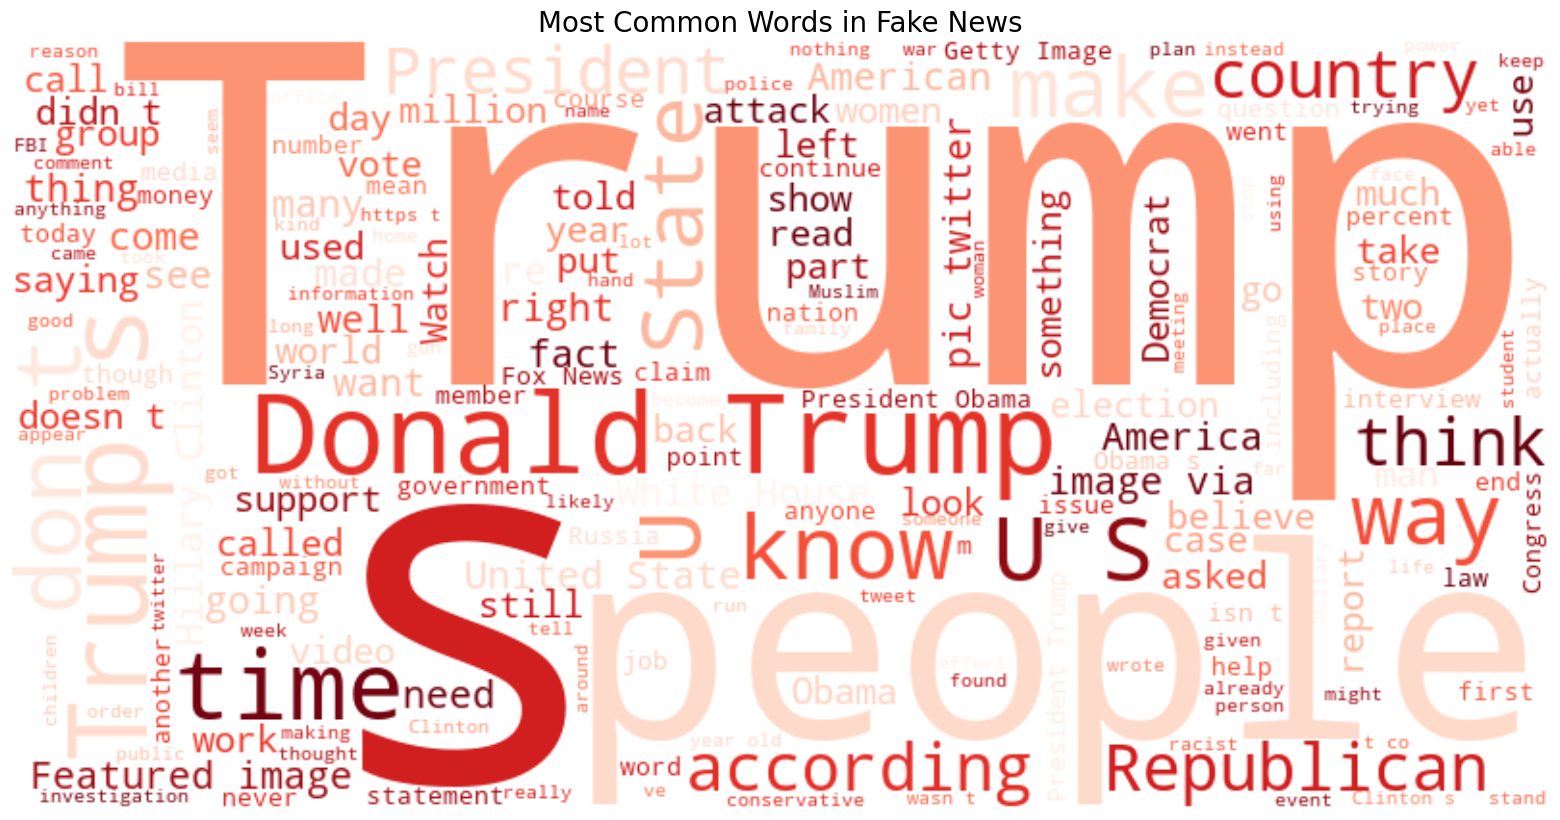

In [36]:
# Word cloud for fake news
plt.figure(figsize=(20, 10))
fake_text = ' '.join(df[df['label'] == 0]['text'].astype(str))
wordcloud_fake = WordCloud(width=800, height=400, 
                          background_color='white',
                          stopwords=custom_stopwords,
                          max_words=200,
                          colormap='Reds').generate(fake_text)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Fake News', fontsize=20)

### Most Common Words in True News

This word cloud shows the most frequent terms used in real news articles, using the same preprocessing and custom stopword filtering as applied to fake news.

Observations:
- True news content is more focused on official reporting and structured narratives. Words like **"Reuters"**, **"White House"**, **"statement"**, **"Tuesday"**, and **"Congress"** suggest factual reporting tied to dates, institutions, and formal processes.
- Names of political figures (e.g., **"Trump"**, **"Donald"**) are still dominant, but are surrounded by more neutral and context-rich words like **"meeting"**, **"plan"**, and **"law"**.
- Compared to the fake news cloud, there’s noticeably less emotionally loaded language and more formal, time-anchored terms like **"Monday"**, **"Friday"**, **"percent"**, and **"report"**.

These patterns reflect the more consistent, structured tone of real journalism — an important distinction for both humans and classifiers to recognize.

Text(0.5, 1.0, 'Most Common Words in True News')

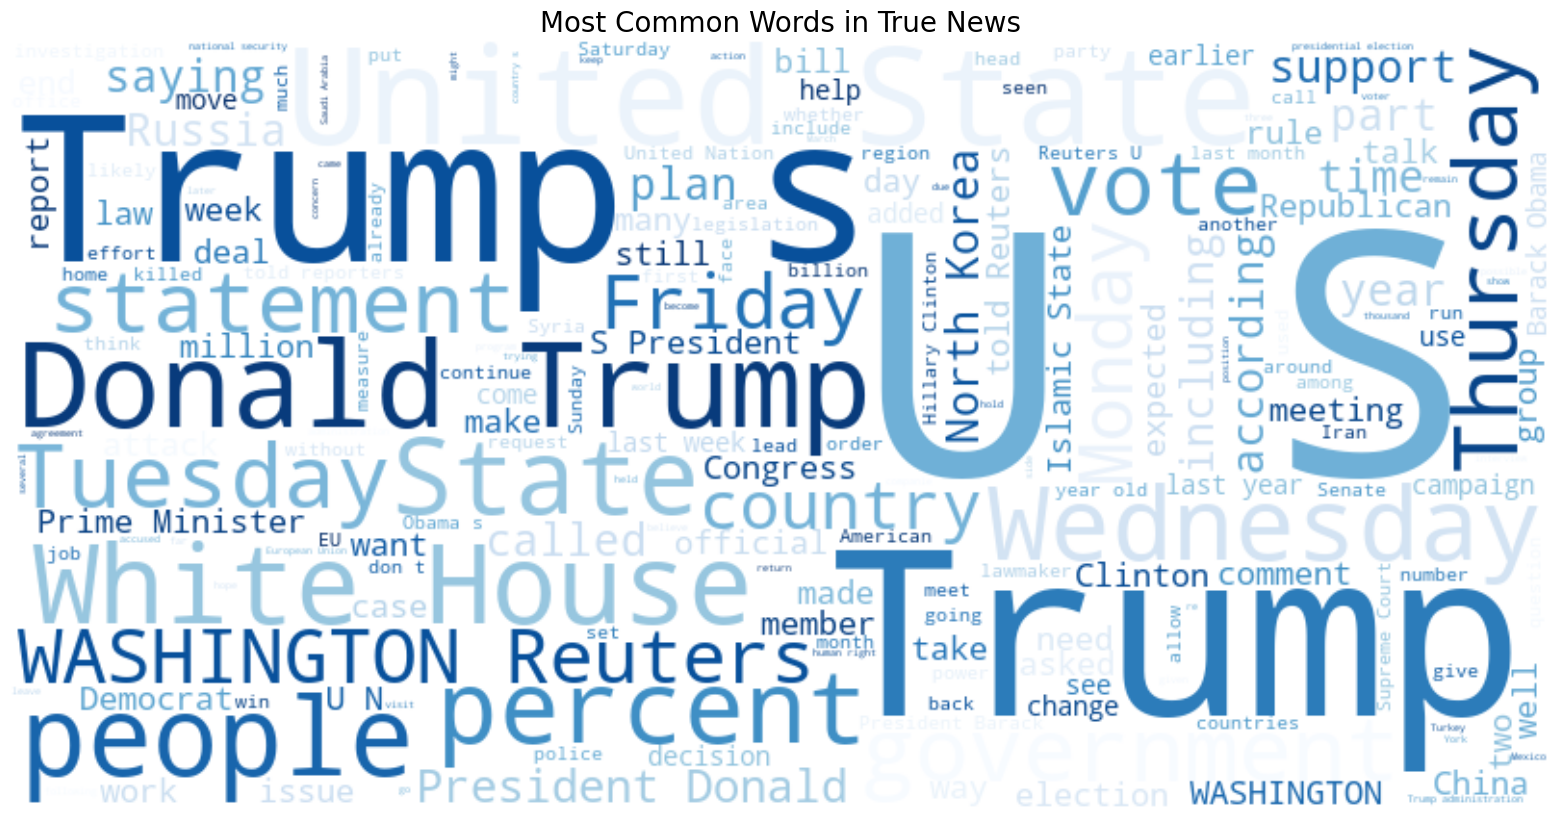

In [39]:
plt.figure(figsize=(20, 10))
true_text = ' '.join(df[df['label'] == 1]['text'].astype(str))
wordcloud_true = WordCloud(width=800, height=400, 
                          background_color='white',
                          stopwords=custom_stopwords,
                          max_words=200,
                          colormap='Blues').generate(true_text)
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in True News', fontsize=20)

### Text Preprocessing

Before feeding raw article text into a model, we clean and normalize it using a custom preprocessing function. This helps standardize the input and remove noise that could negatively affect model performance.

The steps applied are:

1. **Lowercasing**: Converts all text to lowercase to reduce redundancy.
2. **Remove URLs**: Strips out links which often don't add meaningful context.
3. **Remove HTML Tags**: Cleans leftover markup from scraped sources.
4. **Remove Special Characters**: Keeps only alphabetic characters and spaces.
5. **Tokenization**: Splits the text into individual words using `nltk`'s tokenizer.
6. **Stopword Removal**: Filters out common English stopwords like “the”, “and”, etc.
7. **Lemmatization**: Converts words to their root form (e.g., “running” → “run”).
8. **Rejoining Tokens**: Converts the list of cleaned tokens back to a single string.

This cleaned version of the text is stored in a new column `tokens`, and will be used for vectorization and modeling.


In [138]:
def preprocess_text(text):
    """
    Clean and preprocess text data
    """
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
        
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        
        # Rejoin tokens
        text = ' '.join(tokens)
        
        return text
    else:
        return ""

In [139]:
df['tokens'] = df['text'].apply(preprocess_text)

In [140]:
# Get most common words in fake news
fake_words = ' '.join(df[df['label'] == 0]['tokens']).split()
fake_word_counts = Counter(fake_words)
most_common_fake = fake_word_counts.most_common(20)

# Get most common words in true news
true_words = ' '.join(df[df['label'] == 1]['tokens']).split()
true_word_counts = Counter(true_words)
most_common_true = true_word_counts.most_common(20)

In [141]:
# Create DataFrames
fake_words_df = pd.DataFrame(most_common_fake, columns=['word', 'count'])
true_words_df = pd.DataFrame(most_common_true, columns=['word', 'count'])

### Top 20 Most Common Words in Fake News

This bar chart shows the most frequently used words across all fake news articles, based on the cleaned and preprocessed text.

Observations:
- Words like **“trump”**, **“said”**, **“people”**, **“president”**, and **“u”** (likely an artifact from tokenization) appear extremely frequently.
- Many of these words are political in nature or commonly used in opinion-heavy or emotionally charged reporting.
- Despite stopword filtering, some generic terms like **“would”**, **“one”**, and **“also”** still surface — which can be useful to spot tone and phrasing patterns common in misinformation.

This plot helps highlight recurring language that may signal fake content — useful for both interpretation and building interpretable features for classification.


Text(0.5, 0, 'Count')

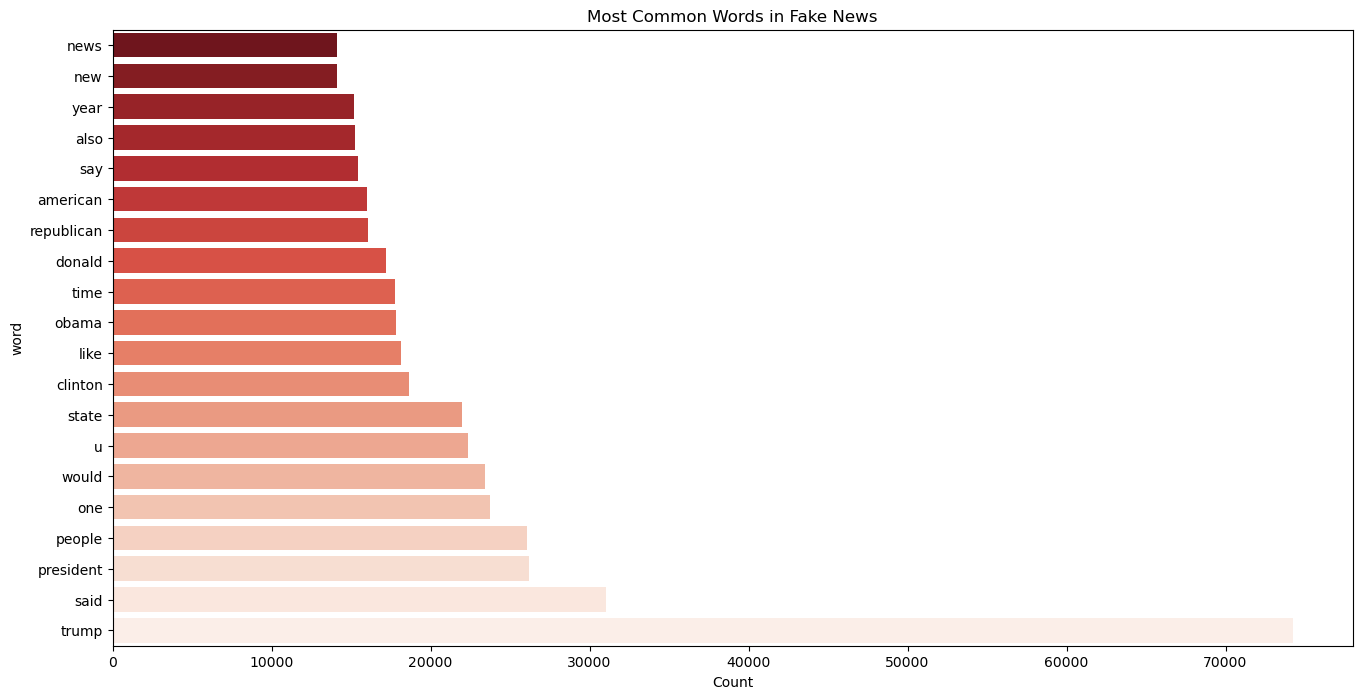

In [146]:
# Plot
plt.figure(figsize=(16, 8))

# Most common words in fake news (reversed order for better y-axis)
sns.barplot(x='count', y='word', hue='word', data=fake_words_df.iloc[::-1], palette='Reds_r', legend=False)
plt.title('Most Common Words in Fake News')
plt.xlabel('Count')

### Top 20 Most Common Words in True News

This bar chart displays the most frequently occurring words in real news articles, based on the cleaned and tokenized text.

Observations:
- Real news emphasizes institutional and formal terms like **"government"**, **"election"**, **"official"**, and **"president"**.
- News agency references such as **"reuters"** and time-related terms like **"year"**, **"told"**, **"week"**, and **"Monday"** suggest structured, report-driven content.
- While some overlap exists with the fake news vocabulary (e.g., **"trump"**, **"said"**, **"people"**), the surrounding context is more factual and grounded in political or legislative topics.
- These words reflect the typical language used in professional reporting, making them useful markers for text classification.

This kind of frequency analysis helps reinforce the linguistic and topical patterns associated with trustworthy journalism.


Text(0.5, 0, 'Count')

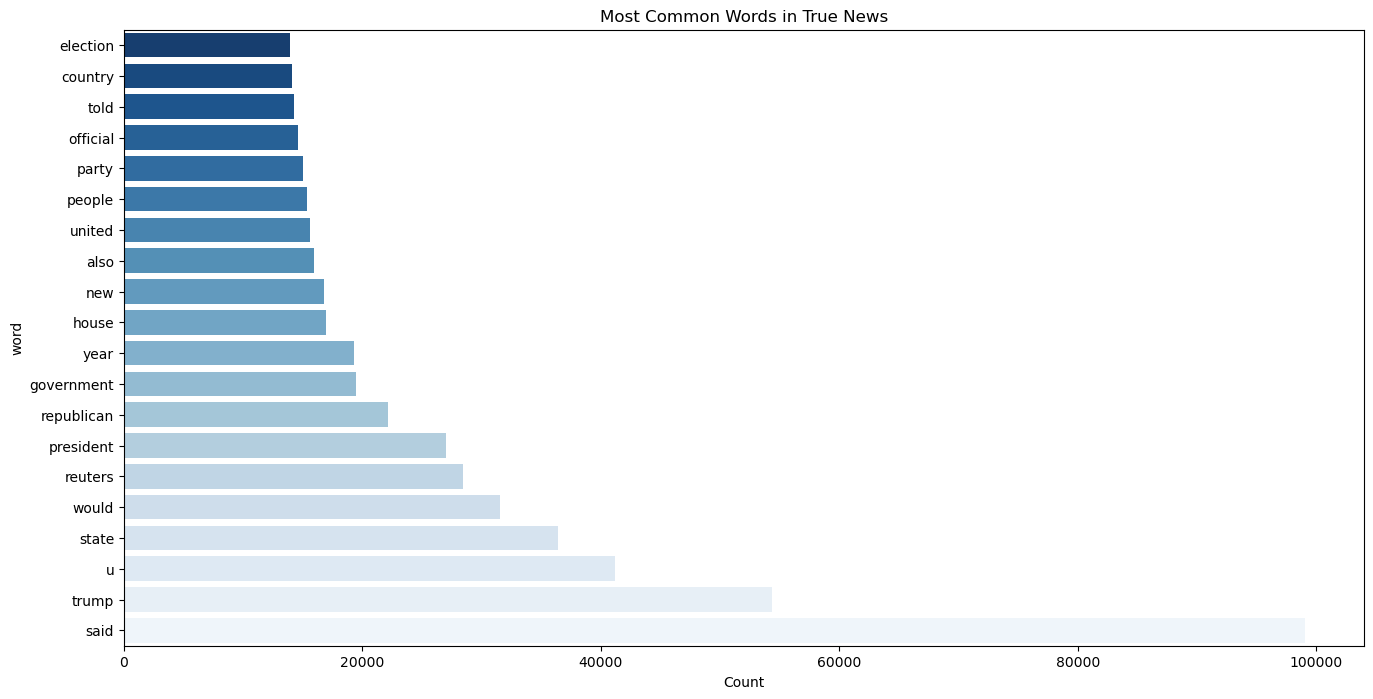

In [144]:
# Most common words in true news
plt.figure(figsize=(16, 8))
sns.barplot(x='count', y='word', hue='word', data=true_words_df.iloc[::-1], palette='Blues_r', legend=False)

plt.title('Most Common Words in True News')
plt.xlabel('Count')

### Correlation Heatmap of Text Features

This heatmap visualizes how various engineered text features relate to one another. It helps us understand which features are strongly associated and which ones offer unique signals.

Key observations:
- **Word count**, **sentence count**, and **punctuation count** are all highly correlated (≥ 0.90), which makes sense since longer articles tend to have more sentences and punctuation marks.
- **Uppercase word count** has moderate correlation with text length and word count, suggesting it scales with article size but not exclusively.
- **Punctuation ratio** is less correlated with length-based features, indicating it's more of a style indicator than a volume metric.
- **Sentiment features** (compound, positive) and **subjectivity** show weak correlations with structural metrics, meaning they capture orthogonal (emotion/tone-based) dimensions — which can be especially useful for identifying fake news patterns.

This correlation matrix helps guide feature selection and dimensionality reduction before model training — especially if we want to avoid redundancy.


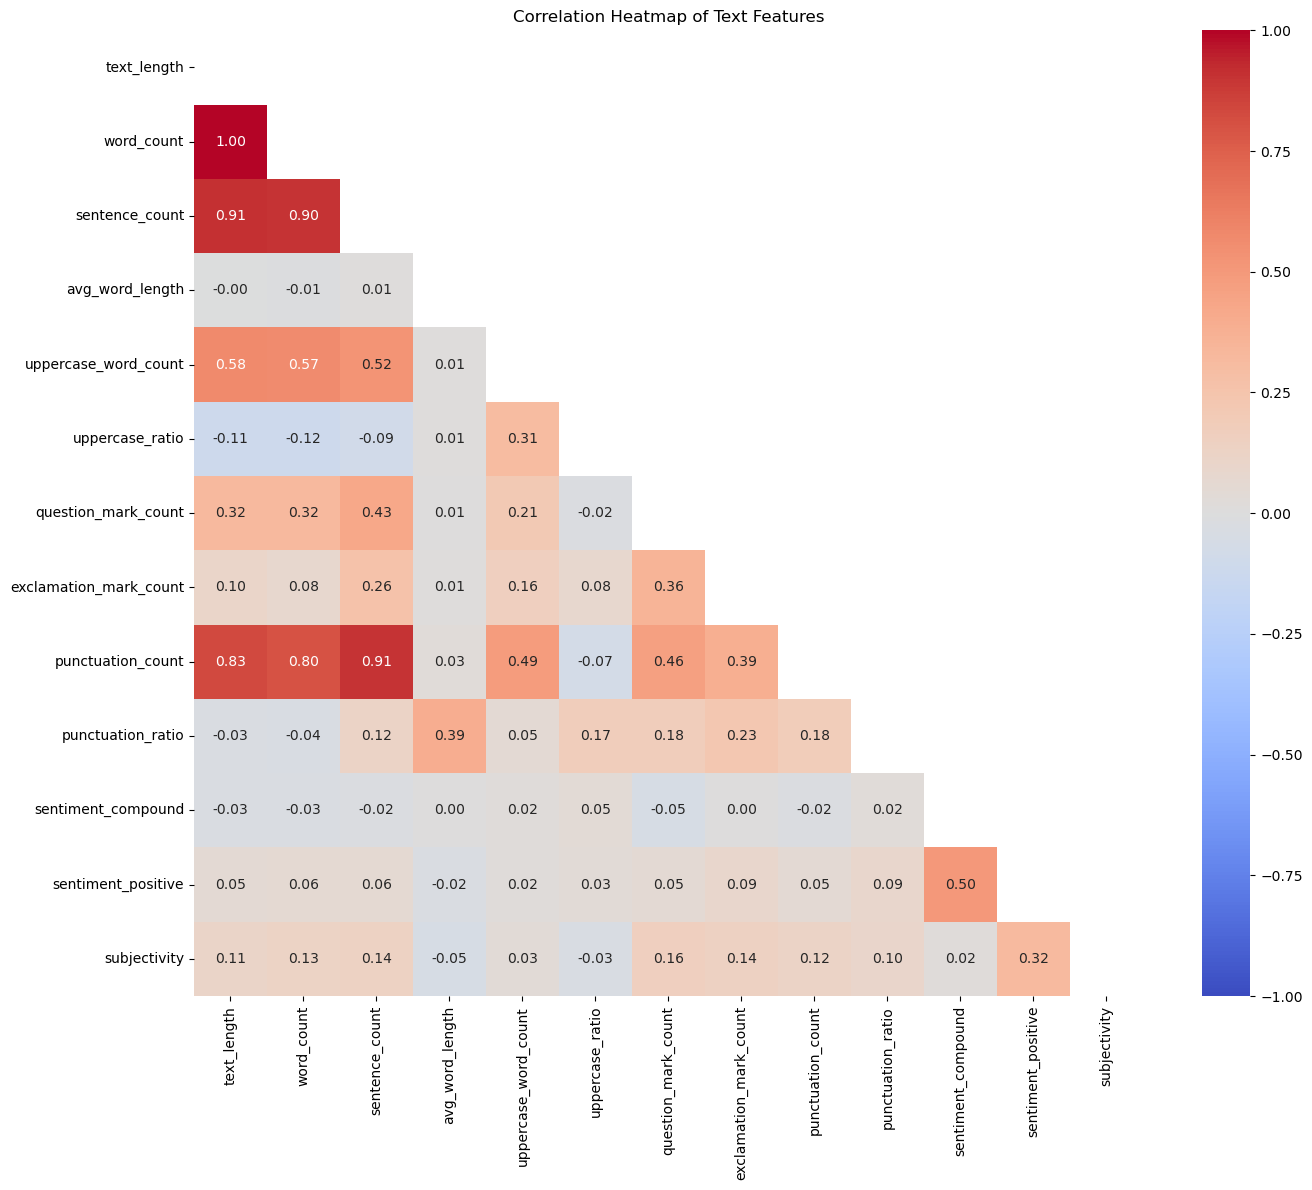

In [70]:
# Select numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).drop(columns=['label'], errors='ignore')

# Calculate correlation matrix
corr_matrix = numerical_features.corr()

# Create heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Text Features')
plt.tight_layout()

# Data Preparation and Feature Extraction

Before training any models, we first prepare the dataset by cleaning the text, splitting it into subsets, and extracting numerical features using TF-IDF.

#### `prepare_data()`

This function:
- Applies the `preprocess_text()` function to clean the raw news text
- Splits the dataset into three sets:
  - **Training set** (70%)
  - **Validation set** (15%)
  - **Test set** (15%)
- Uses **stratified sampling** to maintain label balance across all splits

This ensures our model trains on representative data and can be evaluated fairly on unseen examples.

#### `extract_features()`

This function:
- Uses `TfidfVectorizer` to convert text into numerical feature vectors based on token frequency and inverse document frequency
- Limits features to the top 5000 most informative tokens
- Uses bigrams (`ngram_range=(1, 2)`) to capture word pairs like "fake news" or "Donald Trump"
- Filters out extremely rare (`min_df=5`) and overly common (`max_df=0.8`) terms to reduce noise

The output matrices (`X_train_tfidf`, `X_val_tfidf`, `X_test_tfidf`) are sparse but meaningful representations of the article content, ready for model input.


In [148]:
def prepare_data(df, text_column='text'):
    """
    Preprocess the text data and split into train/validation/test sets
    """
    # Preprocess text
    print("Preprocessing text data...")
    df['processed_text'] = df[text_column].apply(preprocess_text)
    
    # Split data into features and target
    X = df['processed_text']
    y = df['label']
    
    # Split into train, validation, and test sets (70%, 15%, 15%)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    
    print(f"Training set size: {len(X_train)}")
    print(f"Validation set size: {len(X_val)}")
    print(f"Test set size: {len(X_test)}")
    print(f"Train shape: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [149]:
def extract_features(X_train, X_val, X_test, max_features=5000):
    """
    Extract TF-IDF features from the text data
    """
    # TF-IDF Vectorization
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features, 
                                       min_df=5, 
                                       max_df=0.8,
                                       ngram_range=(1, 2))
    
    # Fit and transform training data
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    
    # Transform validation and test data
    X_val_tfidf = tfidf_vectorizer.transform(X_val)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    
    print(f"TF-IDF feature dimensions: {X_train_tfidf.shape[1]}")
    
    return X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vectorizer

In [150]:
# Prepare data
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df)

Preprocessing text data...
Training set size: 31428
Validation set size: 6735
Test set size: 6735
Train shape: (31428,), Validation: (6735,), Test: (6735,)


In [151]:
# Extract features
X_train_tfidf, X_val_tfidf, X_test_tfidf, vectorizer = extract_features(X_train, X_val, X_test)

TF-IDF feature dimensions: 5000


In [79]:
X_train.head()

20630    member president trump diversity council threa...
5980     notorious radical black panther nj cop killer ...
31710    katrina pierson black woman also top spokesper...
36400    great fit tim tebow good man newbie politics p...
23506    washington reuters u republican senator lisa m...
Name: processed_text, dtype: object

### See the structures & shapes of processed data

In [83]:
X_train_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(31428, 5000))

In [84]:
X_val_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(6735, 5000))

In [85]:
X_test_tfidf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.07401076,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(6735, 5000))

In [86]:
y_train.values

array([0, 0, 0, ..., 0, 1, 0], shape=(31428,))

In [87]:
y_val.values

array([0, 0, 1, ..., 0, 0, 1], shape=(6735,))

In [88]:
y_test.values

array([0, 0, 0, ..., 1, 1, 1], shape=(6735,))

In [89]:
# Also save the original text for later reference
pd.DataFrame({'text': X_test, 'label': y_test}).to_csv('../data/test_data_with_text.csv', index=False)

# Model Training and Evaluation

This function handles the full training and evaluation workflow for any classification model.

#### What it does:
- Trains the model on the training data
- Predicts labels for the validation set
- Calculates standard evaluation metrics:
  - **Accuracy**
  - **Precision**
  - **Recall**
  - **F1 Score**
  - **Training time**
- Generates and saves a **confusion matrix** for visual inspection

This setup allows quick model benchmarking and comparison, with performance summaries logged to the console and visual outputs stored for reference.

The function also returns a dictionary containing all key metrics and the trained model itself — ready for further use or ensemble methods.


In [90]:
def train_model(model, X_train, y_train, X_val, y_val, model_name):
    """
    Train and evaluate a model
    """
    print(f"\nTraining {model_name}...")
    start_time = time.time()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on validation set
    y_val_pred = model.predict(X_val)
    
    # Calculate training time
    training_time = time.time() - start_time
    
    # Evaluate the model
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    
    print(f"{model_name} Results:")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Create confusion matrix
    cm = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Fake', 'True'], 
                yticklabels=['Fake', 'True'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.savefig(f'../results/confusion_matrix_{model_name.lower().replace(" ", "_")}.png')
    plt.close()
    
    return {
        'model': model,
        'name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'training_time': training_time
    }

In [93]:
# Define models to train
models = [
    (LogisticRegression(max_iter=1000, C=1.0), "Logistic Regression"),
    (MultinomialNB(), "Naive Bayes"),
    (RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest"),
    (LinearSVC(max_iter=10000), "Linear SVM")
]

In [97]:
models_results = []
for model, model_name in models:
    result = train_model(model, X_train_tfidf, y_train, X_val_tfidf, y_val, model_name)
    models_results.append(result)


Training Logistic Regression...
Logistic Regression Results:
Training time: 0.44 seconds
Accuracy: 0.9863
Precision: 0.9827
Recall: 0.9888
F1 Score: 0.9857

Training Naive Bayes...
Naive Bayes Results:
Training time: 0.01 seconds
Accuracy: 0.9439
Precision: 0.9415
Recall: 0.9409
F1 Score: 0.9412

Training Random Forest...
Random Forest Results:
Training time: 15.93 seconds
Accuracy: 0.9963
Precision: 0.9932
Recall: 0.9991
F1 Score: 0.9961

Training Linear SVM...
Linear SVM Results:
Training time: 0.43 seconds
Accuracy: 0.9938
Precision: 0.9916
Recall: 0.9953
F1 Score: 0.9935


### Model Comparison and Visualization

After training multiple classifiers, we summarize and compare their performance using a single function: `compare_models()`.

#### What it does:
- Creates a clean comparison table with:
  - Accuracy
  - Precision
  - Recall
  - F1 score
  - Training time
- Plots side-by-side bar charts for:
  - Accuracy, Precision, Recall, and F1 score (across all models)
  - Training time to show efficiency vs. performance tradeoffs
    
These comparisons help identify not just the most accurate model, but also the most balanced or efficient one — especially useful when deploying at scale or under compute constraints.

In [103]:
# Compare models
def compare_models(models_results):
    """
    Compare the performance of multiple models
    """
    # Create DataFrame for comparison
    results_df = pd.DataFrame(models_results)
    results_df = results_df[['name', 'accuracy', 'precision', 'recall', 'f1', 'training_time']]
    
    # Display results
    print("\nModel Comparison:")
    print(results_df)
    
    # Create bar chart for metrics comparison
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    plt.figure(figsize=(12, 8))
    
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        sns.barplot(x='name', y=metric, data=results_df)
        plt.title(f'{metric.capitalize()} Comparison')
        plt.xticks(rotation=45)
        plt.tight_layout()
    
#     plt.savefig('../results/model_comparison.png')
#     plt.close()
    
    # Create bar chart for training time
    plt.figure(figsize=(10, 6))
    sns.barplot(x='name', y='training_time', data=results_df)
    plt.title('Training Time Comparison')
    plt.xticks(rotation=45)
    plt.ylabel('Time (seconds)')
    plt.tight_layout()
#     plt.savefig('../results/training_time_comparison.png')
#     plt.close()
    
    return results_df


Model Comparison:
                  name  accuracy  precision    recall        f1  training_time
0  Logistic Regression  0.986340   0.982679  0.988796  0.985728       0.444398
1          Naive Bayes  0.943875   0.941451  0.940865  0.941158       0.014315
2        Random Forest  0.996288   0.993193  0.999066  0.996121      15.927434
3           Linear SVM  0.993764   0.991628  0.995331  0.993476       0.427514


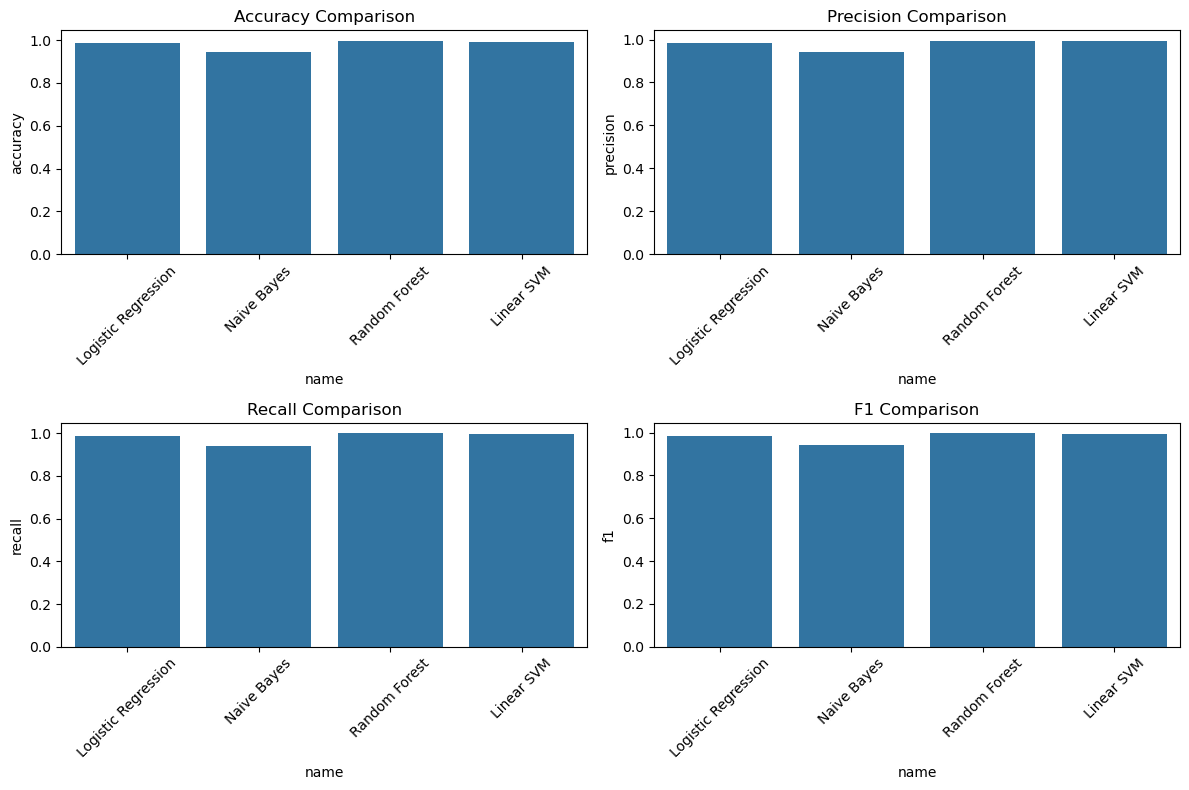

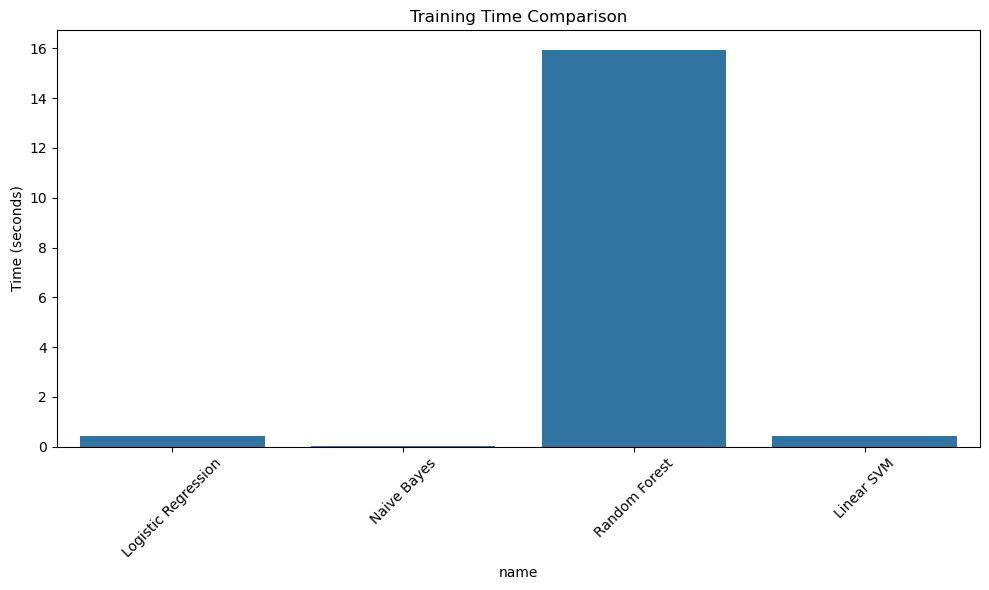

In [104]:
results_df = compare_models(models_results)

In [153]:
print("Model Comparison:")
results_df

Model Comparison:


,name,accuracy,precision,recall,f1,training_time
0,Logistic Regression,0.986340,0.982679,0.988796,0.985728,0.444398
1,Naive Bayes,0.943875,0.941451,0.940865,0.941158,0.014315
2,Random Forest,0.996288,0.993193,0.999066,0.996121,15.927434
3,Linear SVM,0.993764,0.991628,0.995331,0.993476,0.427514


### Final Model Evaluation and Saving

After comparing all trained models, we identify the best one based on **F1 Score**, which balances both precision and recall — crucial for tasks like fake news detection where both false positives and false negatives carry weight.

#### What happens here:

- **Best Model Selection**:
  - We select the model with the highest F1 score from the validation results.

- **Test Set Evaluation**:
  - The best model is evaluated on the unseen test set to assess generalization.
  - We print test metrics: Accuracy, Precision, Recall, and F1 Score.
  - A confusion matrix is generated and saved for visual inspection.

- **Model Export**:
  - The trained model is saved using `pickle` for future use, deployment, or integration.

This wraps up the end-to-end pipeline — from raw text to a trained, validated, and stored classifier ready for production or additional fine-tuning.


In [106]:
# Find the best model based on F1 score
best_model = max(models_results, key=lambda x: x['f1'])
print(f"\nBest model: {best_model['name']} (F1: {best_model['f1']:.4f})")


Best model: Random Forest (F1: 0.9961)


In [107]:
def evaluate_best_model(best_model, X_test, y_test):
    """
    Evaluate the best model on the test set
    """
    print(f"\nEvaluating best model ({best_model['name']}) on test set...")
    
    # Make predictions on test set
    y_test_pred = best_model['model'].predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    
    print(f"Test Results for {best_model['name']}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Fake', 'True'], 
                yticklabels=['Fake', 'True'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Test Set Confusion Matrix - {best_model["name"]}')
    plt.savefig('../results/test_confusion_matrix.png')
    plt.close()
    
    # Save test results
    test_results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    return test_results

In [109]:
# Evaluate best model on test set
test_results = evaluate_best_model(best_model, X_test_tfidf, y_test)


Evaluating best model (Random Forest) on test set...
Test Results for Random Forest:
Accuracy: 0.9970
Precision: 0.9953
Recall: 0.9984
F1 Score: 0.9969


In [112]:
# Save the best model
with open(f'../models/{best_model["name"].lower().replace(" ", "_")}_model.pkl', 'wb') as f:
    pickle.dump(best_model['model'], f)

print(f"\nBest model saved as: ../models/{best_model['name'].lower().replace(' ', '_')}_model.pkl")


Best model saved as: ../models/random_forest_model.pkl
